In [12]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


torch.manual_seed(42)
np.random.seed(42)

# Ways to make better

Here are focused, actionable ideas (no code) to improve accuracy, ordered roughly by expected impact:

High‑impact changes

Use a convolutional neural network (CNN) instead of a fully connected MLP — spatial features matter a lot for images.
Add image normalization (per-channel mean/std) and proper preprocessing pipeline.
Apply data augmentation during training (random crop, small rotations, random horizontal flip, random erasing/cutout, brightness/contrast within small ranges).
Add BatchNorm and Dropout between layers (BatchNorm stabilizes training; Dropout reduces overfitting).
Use an optimizer and LR schedule tuned for your model (AdamW or SGD+momentum with cosine annealing or ReduceLROnPlateau). Try cyclical LR or warmup.
Use weight decay (L2) to regularize weights.
Architecture, regularization, and training

Try smaller/larger models and residual connections — depth vs width tradeoffs matter.
Use pretrained feature extractors (transfer learning) or lightweight architectures (e.g., MobileNet, ResNet variants) adapted for single-channel input.
Use label smoothing or focal loss if hard/imbalanced classes exist.
Use mixed-precision (AMP) for faster experiments to try more configs.
Increase batch size if using stable optimizers, or tune batch size + LR together.
Data and evaluation

Ensure you’re using the correct train/test split (don’t train on the test set). Use the full training set for training and a held-out validation.
Use stratified splits or k-fold cross‑validation for robust hyperparameter selection.
Analyze per-class accuracy and confusion matrix, then target augmentations or class weighting for confused classes.
Use test-time augmentation (TTA) or ensembling multiple model checkpoints for final accuracy gains.
Experimentation strategy

Log curves (train/val loss, accuracy) and check for underfitting vs overfitting before changing architecture.
Run systematic hyperparameter search (random or Bayesian) for LR, weight decay, dropout, hidden sizes.
Start with quick small experiments, then scale up promising configs.
Practical tips

Use early stopping + model checkpointing (save best val model).
Seed and deterministic settings for reproducibility; run each important config multiple times to average performance.
Profile training to ensure GPU is utilized (if available) so experiments finish faster.
If you want, I can prioritize these into a short experiment plan (what to try first, what to measure).

In [13]:
# def load_images(filename):
#     with gzip.open(filename, 'rb') as f:
#         magic_number = int.from_bytes(f.read(4), 'big')
#         num_images = int.from_bytes(f.read(4), 'big')
#         rows = int.from_bytes(f.read(4), 'big')
#         cols = int.from_bytes(f.read(4), 'big')
#         data = np.frombuffer(f.read(), dtype=np.uint8)
#         data = data.reshape(num_images, rows, cols)
#         return data

# def load_labels(filename):
#     with gzip.open(filename, 'rb') as f:
#         magic_number = int.from_bytes(f.read(4), 'big')
#         num_labels = int.from_bytes(f.read(4), 'big')
#         labels = np.frombuffer(f.read(), dtype=np.uint8)
#         return labels


In [14]:
# train_images = load_images("data/test/t10k-images-idx3-ubyte.gz")
# train_labels = load_labels("data/test/t10k-labels-idx1-ubyte.gz")

In [15]:
# i = 0  # change index to view different images
# plt.imshow(train_images[i], cmap='gray')
# plt.title(f"Label: {train_labels[i]}")
# plt.show()

In [16]:
# class FashionDataset(Dataset):
#     def __init__(self, images, labels):
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         image = self.images[idx].astype(np.float32) / 255.0
#         image = torch.tensor(image).view(-1)
#         label = torch.tensor(self.labels[idx]).long()
#         return image, label

# dataset = FashionDataset(train_images, train_labels)
# train_size = int(0.7 * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

In [ ]:
# class FashionNN(nn.Module):
#     def __init__(self, input_size=784,hidden_size=512, hidden_size1=252, hidden_size2=128,hidden_size3=64, output_size=10):
#         super (FashionNN, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size1),
#             nn.ReLU(),
#             nn.Linear(hidden_size1, hidden_size2),
#             nn.ReLU(),
#             nn.Linear(hidden_size2, hidden_size3),
#             nn.ReLU(),
#             nn.Linear(hidden_size3, output_size)
#         )

#     def forward(self, x):
#         return self.model(x)
    
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FashionNN().to(device)

# print(model)

# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'Total trainable parameters: {total_params}')

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        # initial conv
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # residual stages (reduce spatial dim with stride=2)
        self.layer1 = self._make_layer(32, 32, blocks=2, stride=1)
        self.layer2 = self._make_layer(32, 64, blocks=2, stride=2)
        self.layer3 = self._make_layer(64, 128, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Replace previous model instantiation with this:
model = SmallResNet(in_channels=1, num_classes=10).to(device)
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")

Model has 421642 parameters.


In [18]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
class EarlyStopping:
    def __init__(self,patience,min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [20]:
# class ModelTrainer:
#     def __init__(self, model, criterion, optimizer, device,train_loader, test_loader):
#         self.model = model
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.device = device
#         self.train_loader = train_loader
#         self.test_loader = test_loader
#         self.loss_history = []
#         self.val_loss_history = []

#     def calculate_val_loss(self):
#         self.model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for inputs, labels in self.test_loader:
#                 inputs, labels = inputs.to(self.device), labels.to(self.device)
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#         return val_loss / len(self.test_loader.dataset)
    
#     def train_epoch(self):
#         self.model.train()
#         running_loss = 0.0
#         for features, labels in self.train_loader:
#             features, labels = features.to(self.device), labels.to(self.device)

#             self.optimizer.zero_grad()
#             outputs = self.model(features)
#             loss = self.criterion(outputs, labels)
#             loss.backward()
#             self.optimizer.step()

#             running_loss += loss.item() * features.size(0)
        
#         epoch_loss = running_loss / len(self.train_loader.dataset)
#         self.loss_history.append(epoch_loss)
#         return epoch_loss

#     def train(self, num_epochs, early_stopping, scheduler):
#         pbar = tqdm(range(num_epochs), desc='Training', unit='epoch')
#         for epoch in pbar:
#             epoch_loss = self.train_epoch()
#             val_loss = self.calculate_val_loss()

#             self.val_loss_history.append(val_loss)

#             scheduler.step(val_loss)

#             pbar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss})
#             if early_stopping:
#                 early_stopping.step(val_loss)
#                 if early_stopping.early_stop:
#                     print("Early stopping triggered")
#                     break

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimiser, scheduler, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimiser = optimiser
        self.scheduler = scheduler
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

        print(f"Using device: {self.device}")

    def train_epoch(self, epoch, num_epochs):
        self.model.train()
        train_loss = 0.0
        loop = tqdm(self.train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

        for inputs, targets in loop:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimiser.step()

            train_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

        return train_loss / len(self.train_loader.dataset)

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()

        val_loss /= len(self.val_loader.dataset)
        val_acc = correct / len(self.val_loader.dataset)
        return val_loss, val_acc

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch, num_epochs)
            val_loss, val_acc = self.validate()

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            self.scheduler.step(val_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_acc:.4f}")

        print("Training complete.")
        return self.history

In [21]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.show()

Using device: cuda


Epoch [1/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10] - Train Loss: 0.4520, Val Loss: 0.3546, Val Acc: 0.8747


Epoch [2/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10] - Train Loss: 0.2924, Val Loss: 0.3040, Val Acc: 0.8879


Epoch [3/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10] - Train Loss: 0.2449, Val Loss: 0.2680, Val Acc: 0.9057


Epoch [4/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10] - Train Loss: 0.2127, Val Loss: 0.2612, Val Acc: 0.9058


Epoch [5/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10] - Train Loss: 0.1877, Val Loss: 0.2358, Val Acc: 0.9174


Epoch [6/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10] - Train Loss: 0.1653, Val Loss: 0.2259, Val Acc: 0.9200


Epoch [7/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10] - Train Loss: 0.1469, Val Loss: 0.2414, Val Acc: 0.9168


Epoch [8/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10] - Train Loss: 0.1273, Val Loss: 0.2378, Val Acc: 0.9191


Epoch [9/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10] - Train Loss: 0.1107, Val Loss: 0.2500, Val Acc: 0.9183


Epoch [10/10]:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10] - Train Loss: 0.0947, Val Loss: 0.2634, Val Acc: 0.9202
Training complete.
Final Validation Loss: 0.2634, Final Validation Accuracy: 0.9202


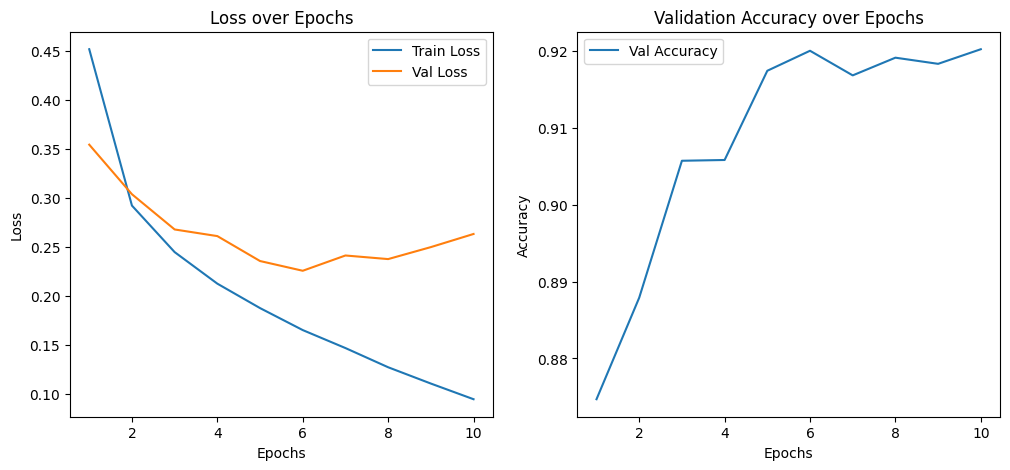

In [22]:
# trainer = ModelTrainer(model, criterion, optimizer, device, train_loader, test_loader)

# num_epochs = 50
# patience = 5
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
# early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

# trainer.train(num_epochs, early_stopping, scheduler)

# loss_history = trainer.loss_history
# val_loss_history = trainer.val_loss_history
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms)
val_ds = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms)

# Use DataLoader directly (imported as DataLoader), not DataLoader.DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

model = CNN(num_classes=10).to(device)
cirterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=3)

trainer = ModelTrainer(model, train_loader, val_loader, cirterion, optimiser, scheduler, device)

history = trainer.train(NUM_EPOCHS)

final_loss, final_acc = trainer.validate()
print(f"Final Validation Loss: {final_loss:.4f}, Final Validation Accuracy: {final_acc:.4f}")
plot_history(history)

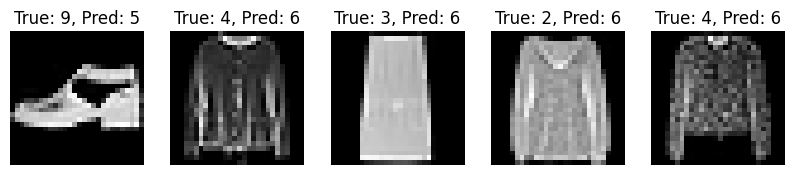

In [23]:
#output the ones it got wrong
model.eval()
incorrect_samples = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(targets)):
            if predicted[i] != targets[i]:
                incorrect_samples.append((inputs[i].cpu(), predicted[i].cpu(), targets[i].cpu()))
# Display some incorrect samples
num_display = 5
plt.figure(figsize=(10, 5))
for i in range(min(num_display, len(incorrect_samples))):
    img, pred, true = incorrect_samples[i]
    plt.subplot(1, num_display, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'True: {true}, Pred: {pred}')
    plt.axis('off')
plt.show()